<a href="https://colab.research.google.com/github/slvDev/Malaria-Detection-CNN-Keras/blob/master/Malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import cv2
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from random import randrange

%matplotlib inline

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [0]:
zip_ref_train = zipfile.ZipFile('/content/drive/My Drive/cell-images-for-detecting-malaria.zip', 'r')
zip_ref_train.extractall('/content')
zip_ref_train.close()

In [0]:
ROOT_DATA_DIR = '/content/cell_images'
INF_DIR = os.path.join(ROOT_DATA_DIR, 'Parasitized')
UNINF_DIR = os.path.join(ROOT_DATA_DIR, 'Uninfected')

inf_fnames = os.listdir(INF_DIR)
uninf_fnames = os.listdir(UNINF_DIR)

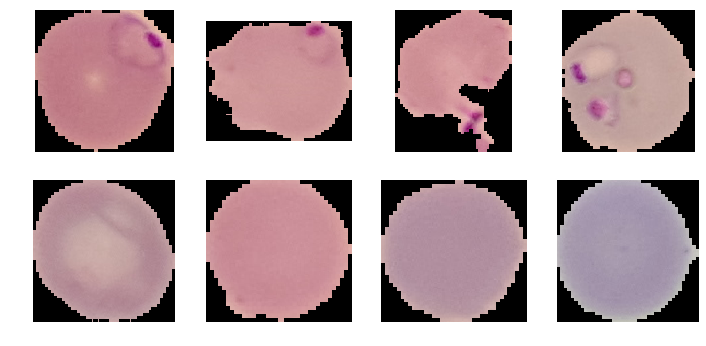

In [61]:
nrows, ncols = 4, 4

fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

inf_pic_paths = [os.path.join(INF_DIR, inf_fnames[randrange(len(inf_fnames))]) 
                for _ in range(4) 
                ]

uninf_pic_paths = [os.path.join(UNINF_DIR, uninf_fnames[randrange(len(uninf_fnames))]) 
                for _ in range(4) 
                ]

for i, img_path in enumerate(inf_pic_paths + uninf_pic_paths):  
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

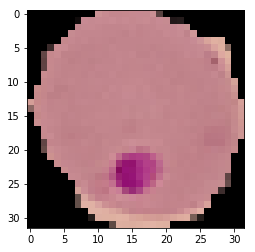

In [70]:
img_size = 32
dim = img_size, img_size

img_path = os.path.join(INF_DIR, inf_fnames[1])
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, dim)

plt.imshow(img)
plt.show()

In [71]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        vertical_flip=True,
        horizontal_flip=True,
        validation_split=0.2,
        )

train_generator = train_datagen.flow_from_directory(
        '/content/cell_images',  
        target_size=dim, 
        batch_size=32,
        class_mode='binary',
        subset='training',
        )

valid_generator = train_datagen.flow_from_directory(
        '/content/cell_images',  
        target_size=dim, 
        batch_size=32,
        class_mode='binary',
        subset='validation',
        )

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [76]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),    
    tf.keras.layers.Dropout(0.2),
       
    tf.keras.layers.Dense(128, activation='relu'),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

In [0]:
history = model.fit_generator(
        train_generator,
        epochs=20,
        validation_data=valid_generator,
        )

Epoch 1/20
689/689 [==============================] - 61s 89ms/step - loss: 0.3487 - acc: 0.8432 - val_loss: 0.2380 - val_acc: 0.9045
Epoch 2/20
689/689 [==============================] - 60s 88ms/step - loss: 0.1603 - acc: 0.9480 - val_loss: 0.1901 - val_acc: 0.9345
Epoch 3/20
689/689 [==============================] - 61s 89ms/step - loss: 0.1439 - acc: 0.9544 - val_loss: 0.2232 - val_acc: 0.9136
Epoch 4/20
689/689 [==============================] - 61s 89ms/step - loss: 0.1384 - acc: 0.9556 - val_loss: 0.1610 - val_acc: 0.9421
Epoch 5/20
689/689 [==============================] - 61s 88ms/step - loss: 0.1322 - acc: 0.9559 - val_loss: 0.1656 - val_acc: 0.9428
Epoch 6/20
689/689 [==============================] - 61s 89ms/step - loss: 0.1272 - acc: 0.9585 - val_loss: 0.1484 - val_acc: 0.9437
Epoch 7/20
689/689 [==============================] - 61s 88ms/step - loss: 0.1234 - acc: 0.9591 - val_loss: 0.1418 - val_acc: 0.9485
Epoch 8/20
689/689 [==============================] - 61s 88ms

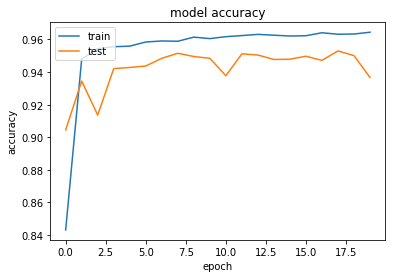

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

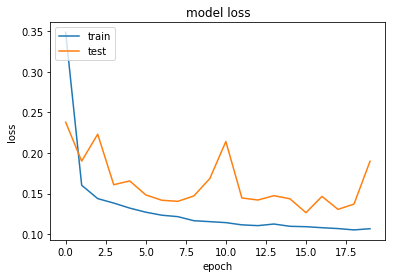

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()